In [40]:
import re
import os
import time
import string
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as tfh
import tensorflow_datasets as tfds
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from bert.tokenization import FullTokenizer
from gensim.models import KeyedVectors as word2vec
from sklearn.model_selection import train_test_split

# Data acquisition

In [2]:
LANGUAGE = "java" #"python"
DATA_PATH = "../../Data/code2desc"
DATA_FOLDER = f"{LANGUAGE}/short"
TRAIN_FILE  = f"{LANGUAGE}_train_0.jsonl"
TEST_FILE   = f"{LANGUAGE}_test_0.jsonl"
VALID_FILE  = f"{LANGUAGE}_valid_0.jsonl"

use_cols = ["code_tokens", "docstring"]

In [8]:
def read_data(scope, n_splits):
    def get_file(scope, split_ind):
        return pd.read_json(f"{DATA_PATH}/{DATA_FOLDER}/{LANGUAGE}_{scope}_{split_ind}.jsonl", lines=True)[use_cols]
    
    train_df = get_file(scope, split_ind=0)
    for i in range(1, n_splits):
        train_df = train_df.append(get_file(scope, split_ind=i), ignore_index=True)
    return train_df

In [9]:
# acquire tokenized source code and plain docstrings.
# BERT uses its own 'FullTokenizer' for inputs.
train_df = read_data(scope='train', n_splits=2)

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   code_tokens  60000 non-null  object
 1   docstring    60000 non-null  object
dtypes: object(2)
memory usage: 937.6+ KB


In [11]:
train_df.head()

,code_tokens,docstring
0,"[protected, final, void, bindIndexed, (, Confi...",Bind indexed elements to the supplied collecti...
1,"[public, void, setServletRegistrationBeans, (,...",Set {@link ServletRegistrationBean}s that the ...
2,"[public, void, addServletRegistrationBeans, (,...",Add {@link ServletRegistrationBean}s for the f...
3,"[public, void, setServletNames, (, Collection,...",Set servlet names that the filter will be regi...
4,"[public, void, addServletNames, (, String, ......",Add servlet names for the filter.\n@param serv...


This TF Hub model uses the implementation of BERT from the TensorFlow Models repository on GitHub at <a href="https://github.com/tensorflow/models/tree/master/official/nlp/bert">tensorflow/models/official/nlp/bert</a>. It uses L=12 hidden layers (i.e., Transformer blocks), a hidden size of H=768, and A=12 attention heads.

This model has been pre-trained for English on the Wikipedia and BooksCorpus using the code published on GitHub. Inputs have been "uncased", meaning that the text has been lower-cased before tokenization into word pieces, and any accent markers have been stripped. For training, random input masking has been applied independently to word pieces (as in the original BERT paper).

All parameters in the module are trainable, and fine-tuning all parameters is the recommended practice.

### Descriptions embeddings

In [17]:
model_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1"
bert_layer = tfh.KerasLayer(model_url, trainable=False)

In [18]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file, do_lower_case)

### Source code embeddings

In [19]:
EMBEDDINGS_FOLDER = "source-code-embeddings"
TOKEN_EMBEDDINGS  = "token_vecs.txt"
TARGET_EMBEDDINGS = "target_vecs.txt"

vectors_text_path = f'{EMBEDDINGS_FOLDER}/{TOKEN_EMBEDDINGS}'
model = word2vec.load_word2vec_format(vectors_text_path, binary=False)

# Data preprocessing

In [20]:
def cleaning(text):
    '''Performs cleaning of text of unwanted symbols, 
    excessive spaces and transfers to lower-case
    '''
#     punct_regxp = re.compile(f'([{string.punctuation}])')
#     text = re.sub(punct_regxp, r" \1 ", text)
    text = re.sub(r'\s+', " ", text)
    
    text = ''.join(character for character in text if character in string.printable)
    text = text.lower().strip()

    return text

In [21]:
train_df.docstring = train_df.docstring.apply(cleaning)

In [22]:
def generate_desc_input(text, max_seq_length):

    tokenized_text = [["[CLS]"] + tokenizer.tokenize(seq)[:max_seq_length-2] + ["[SEP]"] for seq in text]
    input_ids   = [tokenizer.convert_tokens_to_ids(tokens_seq) for tokens_seq in tokenized_text]
    input_mask  = [[1] * len(input_seq) for input_seq in input_ids]
    segment_ids = [[0] * max_seq_length for _ in range(len(input_ids))]
    input_ids = tf.keras.preprocessing.sequence.pad_sequences(input_ids, maxlen=max_seq_length, padding='post')
    input_mask = tf.keras.preprocessing.sequence.pad_sequences(input_mask, maxlen=max_seq_length, padding='post')
    segment_ids = tf.keras.preprocessing.sequence.pad_sequences(segment_ids, maxlen=max_seq_length, padding='post')

    return input_ids, input_mask, segment_ids

In [23]:
desc_max_seq_length = 256
desc_word_ids, desc_input_mask, desc_segment_ids = generate_desc_input(train_df.docstring, desc_max_seq_length)

In [24]:
def generate_sc_input(sc_inputs, emb_model, max_seq_length):
    
    def word_to_index(word):
        word_val = emb_model.vocab.get(word, None)
        word_index = word_val.index if word_val else None
        return word_index
    
    input_ids = [[word_to_index(word) for word in sc_input[:max_seq_length] if word in emb_model.vocab.keys()] \
             for sc_input in sc_inputs]
    input_ids = tf.keras.preprocessing.sequence.pad_sequences(input_ids, 
                                                        dtype='int32', 
                                                        maxlen=max_seq_length, 
                                                        padding='post')
    return input_ids

In [25]:
sc_max_seq_length = 256
sc_ids = generate_sc_input(train_df.code_tokens, model, sc_max_seq_length)

# Model definition

In [26]:
dense_units = 256

### Description branch

In [27]:
input_word_ids = tf.keras.layers.Input(shape=(desc_max_seq_length,), 
                                       dtype=tf.int32,
                                       name="desc_input_word_ids")
input_mask  = tf.keras.layers.Input(shape=(desc_max_seq_length,), 
                                   dtype=tf.int32,
                                   name="desc_input_mask")
segment_ids = tf.keras.layers.Input(shape=(desc_max_seq_length,), 
                                    dtype=tf.int32,
                                    name="desc_segment_ids")

desc_dense = tf.keras.layers.Dense(dense_units, activation='sigmoid', name="desc_dense")

In [17]:
########## Redundant ##########

# # @tf.function
# def desc_propagate(input_word_ids, input_mask, segment_ids):
#     pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
#     desc_output = desc_dense(pooled_output)
#     return desc_output

In [18]:
########## Redundant ##########

# def desc_get_trainable_parameters():
#     tr_vars = desc_dense.trainable_variables
#     return tr_vars

### Source code branch

In [28]:
sc_lstm_units = 256
sc_model = 'convolutional' # 'lstm'
conv_kernel_sizes = [2,3,5]
conv_n_filters = 100

In [29]:
input_sc_ids = tf.keras.layers.Input(shape=(sc_max_seq_length,), 
                                       dtype=tf.int32,
                                       name="sc_input_ids")

sc_embedding = tf.keras.layers.Embedding(len(model.vocab),
                                         model.vector_size, 
                                         weights=[model.vectors],
                                         mask_zero=True,
                                         trainable=False,
                                         name="sc_embedding") # (vocab_size, vec_size) (1294891, 128)

if sc_model == 'convolutional':
    sc_convs = []
    sc_max_pools = []
    for kernel_size in conv_kernel_sizes:
        sc_convs.append(tf.keras.layers.Conv1D(conv_n_filters, kernel_size, activation='relu', name=f'conv_{kernel_size}'))
        sc_max_pools.append(tf.keras.layers.MaxPooling1D(sc_max_seq_length - kernel_size + 1, 1, name=f'max_pool_{kernel_size}'))
elif sc_model == 'lstm':
    sc_lstm = tf.keras.layers.LSTM(sc_lstm_units, name="sc_lstm")

sc_dense = tf.keras.layers.Dense(dense_units, activation='sigmoid', name="sc_dense")

In [21]:
########## Redundant ##########

# # @tf.function
# def sc_propagate(input_sc_ids):
#     sc_embedded_input = sc_embedding(input_sc_ids) # (batch_size, sc_max_seq_length, emb_vec_size)
#     if sc_model == 'convolutional':
#         conv_outputs = []
#         for sc_conv, sc_max_pool in zip(sc_convs, sc_max_pools):
#             sc_conv_out = sc_conv(sc_embedded_input) 
#             conv_outputs.append(sc_max_pool(sc_conv_out))
#         sc_output = tf.concat(conv_outputs, 2) # (batch_size, 1, n_convs * conv_n_filters)
#         sc_output = tf.reshape(sc_output, [-1, len(conv_kernel_sizes) * conv_n_filters]) # (batch_size, n_convs * conv_n_filters)
#     elif sc_model == 'lstm':
#         sc_output = sc_lstm(sc_embedded_input) #  (batch_size, sc_lstm_units)
#     sc_output = sc_dense(sc_output) # (batch_size, dense_units)
#     return sc_output

In [22]:
########## Redundant ##########

# def sc_get_trainable_parameters():
#     tr_vars = sc_dense.trainable_variables + sc_embedding.trainable_variables
#     if sc_model == 'convolutional':
#         for sc_conv in sc_convs:
#             tr_vars += sc_conv.trainable_variables
#     elif sc_model == 'lstm':
#         tr_vars += sc_lstm.trainable_variables
#     return tr_vars

### Branches junction

In [30]:
similarity_mode = 'cosine' # 'cosine' 'dense'

In [24]:
########## Redundant ##########

# if similarity_mode == 'dense':
#     junc_dense = tf.keras.layers.Dense(dense_units, activation='sigmoid', name='junc_dense')
#     junc_sim = tf.keras.layers.Dense(1, activation='sigmoid')
#     junc_output = tf.keras.layers.Flatten()

# # @tf.function
# def compute_similarity(desc_output, sc_output, similarity_mode='cosine'):
#     if similarity_mode == 'cosine':
# #         norm_desc = tf.nn.l2_normalize(desc_output, axis=1, name="desc_output_norm")
# #         norm_sc   = tf.nn.l2_normalize(sc_output, axis=1, name="sc_output_norm") + epsilon
# #         similarity = tf.reduce_sum(tf.multiply(norm_desc, norm_sc, name="b_outputs_dot"), 
# #                                        axis=1, 
# #                                        name="cos_similarity")

#         norm_desc = tf.norm(desc_output, axis=-1, keepdims=True) + 1e-10
#         norm_sc = tf.norm(sc_output, axis=-1, keepdims=True) + 1e-10
#         cosine_similarities = tf.matmul(desc_output / norm_desc,
#                                         sc_output / norm_sc,
#                                         transpose_a=False,
#                                         transpose_b=True,
#                                         name='code_query_cooccurrence_logits')  # (batch_size, batch_size)
#         similarity_scores = cosine_similarities

#         # A max-margin-like loss, but do not penalize negative cosine similarities.
#         neg_matrix = tf.linalg.diag(tf.fill(dims=[tf.shape(cosine_similarities)[0]], value=float('-inf')))
#         per_sample_loss = tf.maximum(0., loss_margin
#                                          - tf.linalg.diag_part(cosine_similarities)
#                                          + tf.reduce_max(tf.nn.relu(cosine_similarities + neg_matrix),
#                                                          axis=-1))

#         per_sample_loss = per_sample_loss * labels
#         similarity = tf.reduce_sum(per_sample_loss) / tf.reduce_sum(labels)

# #         # extract the logits from the diagonal of the matrix, which are the logits corresponding to the ground-truth
# #         correct_scores = tf.linalg.diag_part(similarity_scores)
# #         # compute how many queries have bigger logits than the ground truth (the diagonal) -> which will be incorrectly ranked
# #         compared_scores = similarity_scores >= tf.expand_dims(correct_scores, axis=-1)
# #         # for each row of the matrix (query), sum how many logits are larger than the ground truth
# #         # ...then take the reciprocal of that to get the MRR for each individual query (you will need to take the mean later)
# #         mrr = 1 / tf.reduce_sum(tf.cast(compared_scores, dtype=tf.float32), axis=1)

#     if similarity_mode == 'dense':
#         dense_output = junc_dense(tf.multiply(desc_output, sc_output, name="b_outputs_dot"))
#         similarity = junc_sim(dense_output)
#         similarity = junc_output(similarity)
        
#     return similarity

# def junc_get_trainable_parameters():
#     tr_vars = []
#     if similarity_mode == 'dense':
#         tr_vars += junc_dense.trainable_variables + junc_sim.trainable_variables
#     return tr_vars

### Full Model

In [31]:
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
desc_output = desc_dense(pooled_output)

sc_embedded_input = sc_embedding(input_sc_ids) # (batch_size, sc_max_seq_length, emb_vec_size)

conv_outputs = []
for sc_conv, sc_max_pool in zip(sc_convs, sc_max_pools):
    sc_conv_out = sc_conv(sc_embedded_input) 
    conv_outputs.append(sc_max_pool(sc_conv_out))
sc_output = tf.concat(conv_outputs, 2) # (batch_size, 1, n_convs * conv_n_filters)
sc_output = tf.reshape(sc_output, [-1, len(conv_kernel_sizes) * conv_n_filters]) # (batch_size, n_convs * conv_n_filters)
sc_output = sc_dense(sc_output)

norm_desc = tf.norm(desc_output, axis=-1, keepdims=True) + 1e-10
norm_sc   = tf.norm(sc_output, axis=-1, keepdims=True) + 1e-10
cos_similarity = tf.matmul(desc_output / norm_desc,
                                sc_output / norm_sc,
                                transpose_a=False,
                                transpose_b=True,
                                name='code_query_cooccurrence_logits')  # (batch_size, batch_size)

In [118]:
def cos_loss(dummy, cosine_similarities):
    loss_margin = 1.0
    # A max-margin-like loss, but do not penalize negative cosine similarities.
    neg_matrix = tf.linalg.diag(tf.fill(dims=[tf.shape(cosine_similarities)[0]], value=float('-inf')))
    per_sample_loss = tf.maximum(0., loss_margin
                                     - tf.linalg.diag_part(cosine_similarities)
                                     + tf.reduce_max(tf.nn.relu(cosine_similarities + neg_matrix),
                                                     axis=-1))

    loss = tf.reduce_mean(per_sample_loss)
    return loss

def mrr(dummy, cosine_similarities):
    # extract the logits from the diagonal of the matrix, which are the logits corresponding to the ground-truth
    correct_scores = tf.linalg.diag_part(cosine_similarities)
    # compute how many queries have bigger logits than the ground truth (the diagonal) -> which will be incorrectly ranked
    compared_scores = cosine_similarities >= tf.expand_dims(correct_scores, axis=-1)
    # for each row of the matrix (query), sum how many logits are larger than the ground truth
    # ...then take the reciprocal of that to get the MRR for each individual query (you will need to take the mean later)
    mrr = 1 / tf.reduce_sum(tf.cast(compared_scores, dtype=tf.float32), axis=1)
    return mrr

In [33]:
inputs = [input_word_ids, input_mask, segment_ids, input_sc_ids]
outputs = cos_similarity

sim_model = tf.keras.Model(inputs=inputs, outputs=outputs)

optimizer = tf.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "./logs/fit/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "./model_checkpoints/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,  
                                                 save_best_only=True, 
                                                 save_weights_only=True)

sim_model.compile(loss=cos_loss, optimizer=optimizer, metrics=[mrr])

In [34]:
sim_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sc_input_ids (InputLayer)       [(None, 256)]        0                                            
__________________________________________________________________________________________________
sc_embedding (Embedding)        (None, 256, 128)     165746048   sc_input_ids[0][0]               
__________________________________________________________________________________________________
conv_2 (Conv1D)                 (None, 255, 100)     25700       sc_embedding[0][0]               
__________________________________________________________________________________________________
conv_3 (Conv1D)                 (None, 254, 100)     38500       sc_embedding[0][0]               
______________________________________________________________________________________________

# Model Training

In [27]:
########## Redundant ##########

# def loss_function(y_true, y_pred, n_negatives):

#     loss = loss_func(y_true, y_pred)
# #     weight_vector = y_true * tr_weights[0] + (1.-y_true) * tr_weights[1]
#     return tf.reduce_mean(loss)# * weight_vector)

# def negative_sampling(desc_output, sc_output, n_negatives):
#     neg_probs = tf.linalg.set_diag(tf.fill([batch_size, batch_size], 0.5),[0]*batch_size)
#     neg_ids   = tf.random.categorical(neg_probs, n_negatives)

#     neg_desc = tf.reshape(tf.gather(desc_output, neg_ids), [-1, dense_units])
#     neg_sc   = tf.reshape(tf.gather(sc_output, [[i]*n_negatives for i in range(batch_size)]), [-1, dense_units])

#     desc_output = tf.concat([desc_output,neg_desc], axis=0)
#     sc_output   = tf.concat([sc_output,neg_sc], axis=0)
    
#     return desc_output, sc_output

# @tf.function
# def train_step(input_word_ids, input_mask, segment_ids, input_sc_ids, batch_size, n_negatives):

#     with tf.GradientTape() as tape:
        
#         desc_output = desc_propagate(input_word_ids, input_mask, segment_ids)
#         sc_output = sc_propagate(input_sc_ids)
        
# #         desc_output, sc_output = negative_sampling(desc_output, sc_output, n_negatives)
#         loss = compute_similarity(desc_output, sc_output, similarity_mode)
# #         labels = np.array([1.] * batch_size + [0.] * (batch_size * n_negatives))
# #         loss = loss_function(labels, cos_similarity, n_negatives)
        
#     # Adjust the parameters of the model using the computed gradients
#     variables = desc_get_trainable_parameters() + sc_get_trainable_parameters() + junc_get_trainable_parameters()
#     gradients = tape.gradient(loss, variables)
#     optimizer.apply_gradients(zip(gradients, variables))

#     return loss

# @tf.function
# def validation_step(input_word_ids, input_mask, segment_ids, input_sc_ids, batch_size, n_negatives):

#     desc_output = desc_propagate(input_word_ids, input_mask, segment_ids)
#     sc_output = sc_propagate(input_sc_ids)

# #     desc_output, sc_output = negative_sampling(desc_output, sc_output, n_negatives)
#     loss = compute_similarity(desc_output, sc_output, similarity_mode)
# #     labels = np.array([1.] * batch_size + [0.] * (batch_size * n_negatives))
# #     loss = loss_function(labels, cos_similarity, n_negatives)
    
#     return loss

In [35]:
splitted_data = train_test_split(desc_word_ids, desc_input_mask, desc_segment_ids, sc_ids)
train_desc_word_ids, test_desc_word_ids = splitted_data[:2]
train_desc_input_mask, test_desc_input_mask = splitted_data[2:4]
train_desc_segment_ids, test_desc_segment_ids = splitted_data[4:6]
train_sc_ids, test_sc_ids = splitted_data[6:8]

In [36]:
batch_size = 256
train_samples = len(train_desc_word_ids)
valid_samples = len(test_desc_word_ids)
train_steps_per_epoch = train_samples // batch_size
valid_steps_per_epoch = valid_samples // batch_size
epochs = 10

########## Redundant ##########

# n_negatives = 30
# val_n_negatives = 30

In [37]:
train_data = tf.data.Dataset.from_tensor_slices(((train_desc_word_ids, train_desc_input_mask, train_desc_segment_ids, train_sc_ids), np.ones((len(train_desc_word_ids),1)))).shuffle(len(train_desc_word_ids), reshuffle_each_iteration=True).batch(batch_size, drop_remainder=True)
valid_data = tf.data.Dataset.from_tensor_slices(((test_desc_word_ids, test_desc_input_mask, test_desc_segment_ids, test_sc_ids), np.ones((len(test_desc_word_ids),1)))).shuffle(len(test_desc_word_ids), reshuffle_each_iteration=True).batch(batch_size, drop_remainder=True)

In [38]:
train_hist = sim_model.fit(train_data, 
                           epochs=epochs,
                           validation_data=valid_data,
                           callbacks=[cp_callback])

Train for 175 steps, validate for 58 steps
Epoch 1/10
175/175 [==============================] - 1705s 10s/step - loss: 1.0040 - mrr: 0.0250 - val_loss: 1.0022 - val_mrr: 0.0261
Epoch 2/10
175/175 [==============================] - 1761s 10s/step - loss: 1.0020 - mrr: 0.0264 - val_loss: 1.0018 - val_mrr: 0.0267
Epoch 3/10
175/175 [==============================] - 1775s 10s/step - loss: 1.0016 - mrr: 0.0277 - val_loss: 1.0016 - val_mrr: 0.0281
Epoch 4/10
175/175 [==============================] - 1726s 10s/step - loss: 1.0014 - mrr: 0.0289 - val_loss: 1.0014 - val_mrr: 0.0292
Epoch 5/10
175/175 [==============================] - 1702s 10s/step - loss: 1.0013 - mrr: 0.0302 - val_loss: 1.0012 - val_mrr: 0.0306
Epoch 6/10
175/175 [==============================] - 1746s 10s/step - loss: 1.0012 - mrr: 0.0323 - val_loss: 1.0012 - val_mrr: 0.0320
Epoch 7/10
175/175 [==============================] - 1733s 10s/step - loss: 1.0011 - mrr: 0.0333 - val_loss: 1.0011 - val_mrr: 0.0330
Epoch 8/10
1

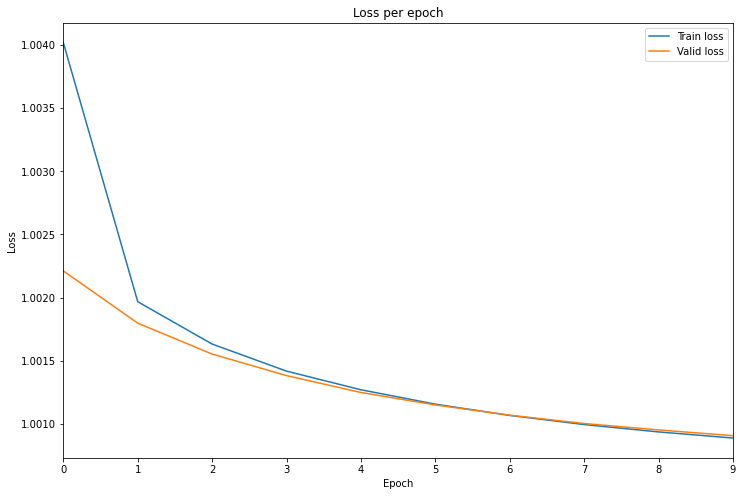

In [65]:
plt.figure(figsize=(12,8))
plt.plot(train_hist.history['loss'], label='Train loss')
plt.plot(train_hist.history['val_loss'], label='Valid loss')
plt.title('Loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.linspace(0, epochs-1, epochs))
plt.xlim(0,epochs-1)
plt.legend()
plt.show()

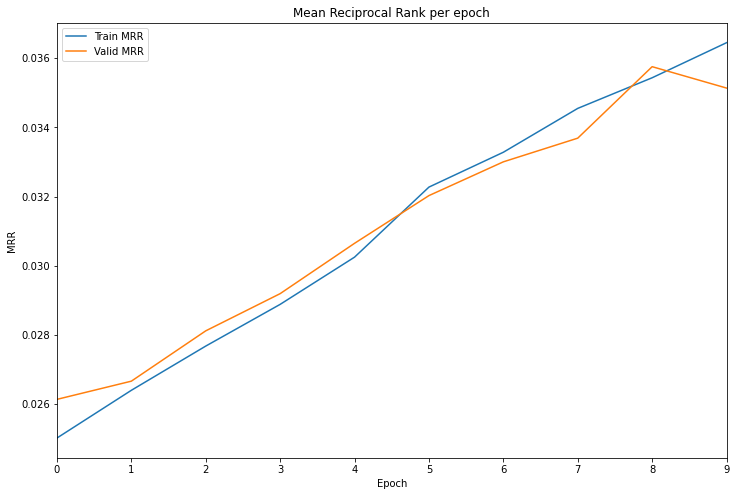

In [64]:
plt.figure(figsize=(12,8))
plt.plot(train_hist.history['mrr'], label='Train MRR')
plt.plot(train_hist.history['val_mrr'], label='Valid MRR')
plt.title('Mean Reciprocal Rank per epoch')
plt.xticks(np.linspace(0, epochs-1, epochs))
plt.xlabel('Epoch')
plt.ylabel('MRR')
plt.xlim(0,epochs-1)
plt.legend()
plt.show()

# Evaluation

In [89]:
(input_word_ids, input_mask, segment_ids, input_sc_ids), dummy = list(valid_data.take(1).as_numpy_iterator())[0]
cs = sim_model.predict((input_word_ids, input_mask, segment_ids, input_sc_ids), batch_size=batch_size)

In [103]:
cs

array([[0.97294784, 0.9731096 , 0.9713819 , ..., 0.972601  , 0.97272325,
        0.97311085],
       [0.96496105, 0.9656031 , 0.96401227, ..., 0.9660008 , 0.9653147 ,
        0.96593964],
       [0.9723942 , 0.9714621 , 0.9705059 , ..., 0.9722726 , 0.9725827 ,
        0.9712437 ],
       ...,
       [0.9729866 , 0.9723158 , 0.97226405, ..., 0.97330034, 0.97305906,
        0.9728131 ],
       [0.977633  , 0.976761  , 0.975512  , ..., 0.9772631 , 0.9779841 ,
        0.9767438 ],
       [0.9647894 , 0.96491563, 0.96255696, ..., 0.96395093, 0.9646472 ,
        0.9652592 ]], dtype=float32)

In [120]:
mrr(1,cs)

<tf.Tensor: shape=(256,), dtype=float32, numpy=
array([0.00714286, 0.00657895, 0.00393701, 0.01      , 0.01010101,
       0.00578035, 0.0212766 , 0.00578035, 0.00584795, 0.00769231,
       0.0625    , 0.01176471, 0.01052632, 0.01098901, 0.00507614,
       0.09090909, 0.01369863, 0.0075188 , 0.00543478, 0.00529101,
       0.16666667, 0.00826446, 0.25      , 0.00502513, 0.33333334,
       0.01219512, 0.01369863, 0.00952381, 0.03125   , 0.04545455,
       0.00934579, 0.00531915, 1.        , 0.00662252, 0.00462963,
       0.0106383 , 0.00396825, 0.00510204, 0.02564103, 0.00392157,
       0.02      , 0.0047619 , 0.00392157, 0.02702703, 0.08333334,
       0.00446429, 0.01428571, 0.00406504, 0.02      , 0.02857143,
       0.00512821, 0.00724638, 0.00714286, 0.00847458, 0.02083333,
       0.125     , 0.03125   , 0.01408451, 0.01136364, 0.0106383 ,
       0.02631579, 0.2       , 0.06666667, 0.00392157, 0.01234568,
       0.0070922 , 0.0045045 , 0.00699301, 0.01492537, 0.0125    ,
       0.1    

In [128]:
def evaluate_cos_similarity(desc_text, sc_text):
    desc_word_ids, desc_input_mask, desc_segment_ids = generate_desc_input([desc_text], desc_max_seq_length)
    sc_ids = generate_sc_input([sc_text], model, sc_max_seq_length)
    
    res = sim_model.predict((desc_word_ids, desc_input_mask, desc_segment_ids, sc_ids), batch_size=batch_size)

    return res

def evaluate_cos_similarities(desc_texts, sc_texts):
    desc_word_ids, desc_input_mask, desc_segment_ids = generate_desc_input(desc_texts, desc_max_seq_length)
    sc_ids = generate_sc_input(sc_texts, model, sc_max_seq_length)
    
    res = sim_model.predict((desc_word_ids, desc_input_mask, desc_segment_ids, sc_ids), batch_size=batch_size)

    return res

In [132]:
rand_sim_ind = np.random.randint(0, len(train_df))
rand_dif_ind = np.random.randint(0, len(train_df))
print(f"Doc 1: {train_df.docstring[rand_sim_ind]}\n")
print(f"Doc 2: {train_df.docstring[rand_dif_ind]}\n")
sim_matr = evaluate_cos_similarities(train_df.iloc[[rand_sim_ind, rand_dif_ind]].docstring, 
                                     train_df.iloc[[rand_sim_ind, rand_dif_ind]].code_tokens)
print(f"Similaity matrix:\n{sim_matr}")

Doc 1: the resources (packages) that api exposes to plugins. other core classes (sonarqube, mybatis, ...) can't be accessed. <p>to sum-up, these are the classes packaged in sonar-plugin-api.jar or available as a transitive dependency of sonar-plugin-api</p>

Doc 2: converts output of autoencoder to a rowdata structure. categorical fields are represented by a map of domain values -> reconstructed values, missing domain value is represented by a 'null' key @param reconstructed raw output of autoencoder @return reconstructed rowdata structure

Similaity matrix:
[[0.9716594 0.9715037]
 [0.9672979 0.9671995]]
